In [1]:
from SFS.src.py.utils import *
from numpy.fft import fft2, ifft, ifft2, fft, fftfreq, fftshift, ifftshift, rfftfreq, rfft2
from IPython.display import HTML

In [2]:
number = 4
folder = "data/SETD1/{n}/".format(n=number)
folder = "data/SETD_paper/{n}/".format(n=number)
num = count_files(folder)
print(num)

96


In [3]:
vid_notebook(folder, 0, skip=20, size=2)

In [4]:
def get_K(field, q, con):
    r, u = con["r"], con["u"]
    phiq = 1j*q * ifft2(field)
    phi = fft2(phiq)
    return u * phi**2 / 2

In [5]:
fn = "varphi"
field_av = get_field(folder + "{m}/".format(m = 1), fn)
for i in range(1, num):
    field_av += get_field(folder + "{m}/".format(m=i+1), fn)
field_av = field_av / num
field_av = np.mean(field_av, axis=1)[:, None]

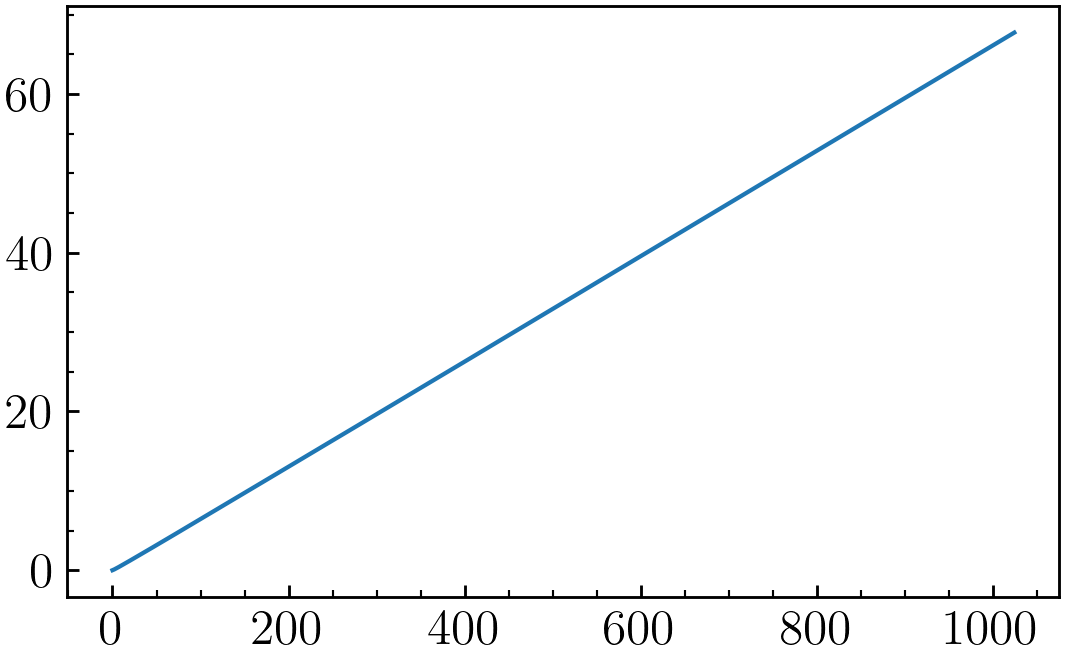

In [6]:
fig, ax = plt.subplots(figsize=(5,3)) 
plt.plot(field_av[:,0])

In [7]:
run_folder = folder + "{m}/".format(m = 3)
field = get_field(run_folder, fn) - field_av
param = get_para(run_folder)
run_folder = folder+"{}/".format(1)
X, d, N, L, T, dt, con = param
a, figv = anim_fields_array([field,], param, skip=20, size=2, interval=50)
figv.tight_layout()
display(HTML(a.to_jshtml()))
plt.close(figv)

In [8]:
print(L, N, T, con["u"])

512.0 1024 0.01 50.0


In [9]:
def get_w2(seed, folder, start=1):
    run_folder = folder + "{m}/".format(m = seed)
    X, d, N, L, T, dt, con = get_para(run_folder)
    time = get_time(run_folder)

    field = get_field(run_folder, fn)
    nt, nx = np.shape(field)
    lnt = int(np.log2(nt))
    lnx = int(np.log2(nx))
    w2 = np.zeros((lnt-start, lnx-start))

    for i in range(start,lnt): # Time step
        ii = 2**(i+1)
        for j in range(start,lnx):
            jj = 2**(j+1)   # points in window
            nw = nx//jj     # Number of windows in the system
            for k in range(nw):
                i1, i2 = k*jj, (k+1)*jj
                htx = field[ii, i1:i2]
                w2[i-start,j-start] += (np.mean(htx**2) - np.mean(htx)**2) / nw

    xx = np.array([X[0][2**(j+1)-1] for j in range(start,lnx)])
    tt = np.array([time[2**(i+1)] for i in range(start,lnt)])

    return w2, xx, tt

In [10]:
w2, xx, tt = get_w2(1, folder)
for i in range(1, num): w2 += get_w2(i+1, folder)[0]
w = np.sqrt(w2 / num)

nt, nx = np.shape(w)
print(nt,nx)

9 9


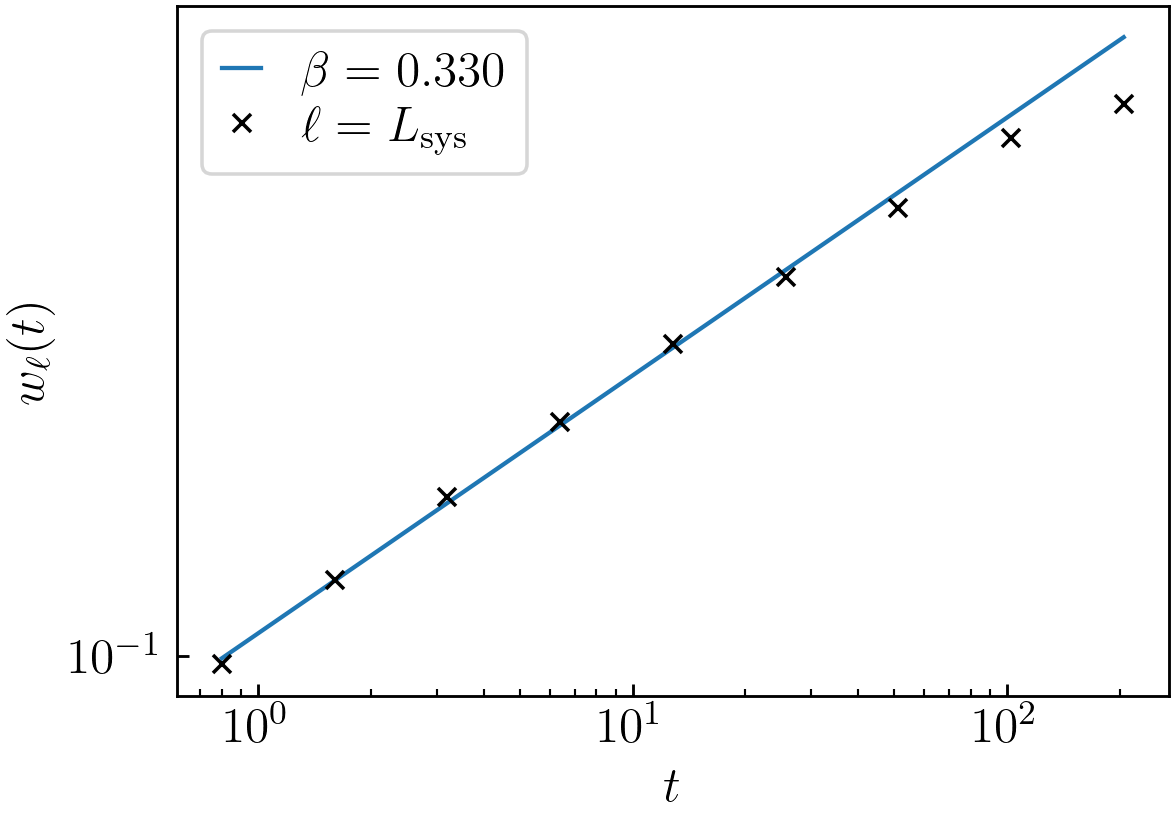

In [11]:
NN = -3
MM = None
b, c = np.polyfit(np.log(tt[MM:NN]), np.log(w[MM:NN,-1]), 1)
fig, ax = plt.subplots()
ax.plot(tt, np.exp(c)*tt**b, label='$\\beta = {b:.3f}$'.format(b=b))
ax.loglog(tt, w[:, -1], 'xk', label='$\\ell = L_{\\mathrm{sys}}$')
ax.legend()
ax.set_xlabel("$t$")
ax.set_ylabel("$w_\\ell(t)$")
ax.set_yticks([], minor=True)
plt.show()

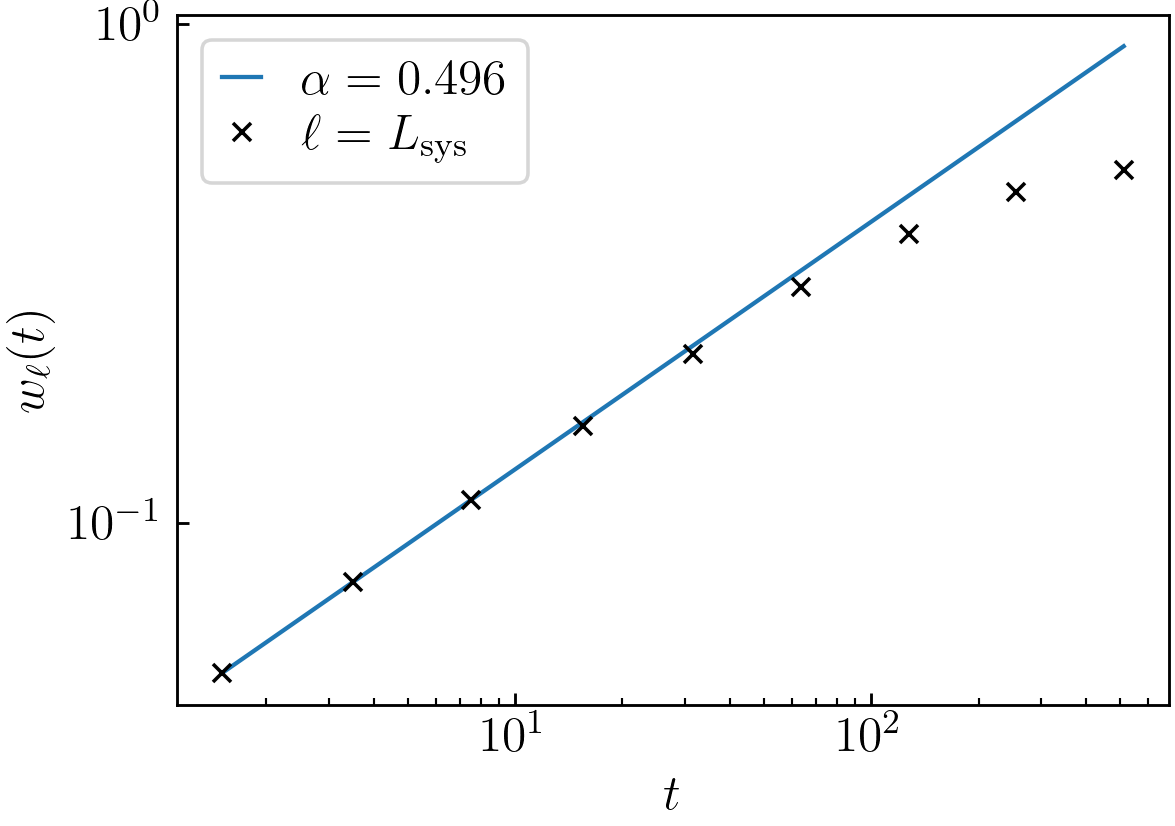

In [12]:
NN = 3
MM = None
X, Y = xx, w[-1]
a, c = np.polyfit(np.log(X[MM:NN]), np.log(Y[MM:NN]), 1)
fig, ax = plt.subplots()
ax.plot(X, np.exp(c)*X**a, label='$\\alpha = {a:.3f}$'.format(a=a))
ax.loglog(X, Y, 'xk', label='$\\ell = L_{\\mathrm{sys}}$')
ax.legend()
ax.set_xlabel("$t$")
ax.set_ylabel("$w_\\ell(t)$")
ax.set_yticks([], minor=True)
plt.show()

In [13]:
a = 1/2
b = 1/3

z = a / b
print(a, b, z)

0.5 0.3333333333333333 1.5


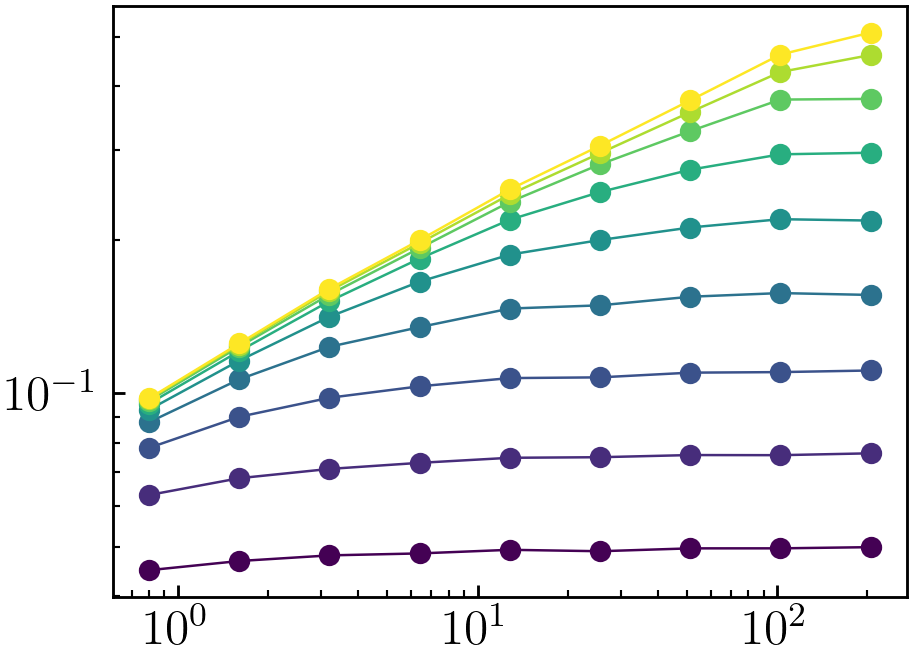

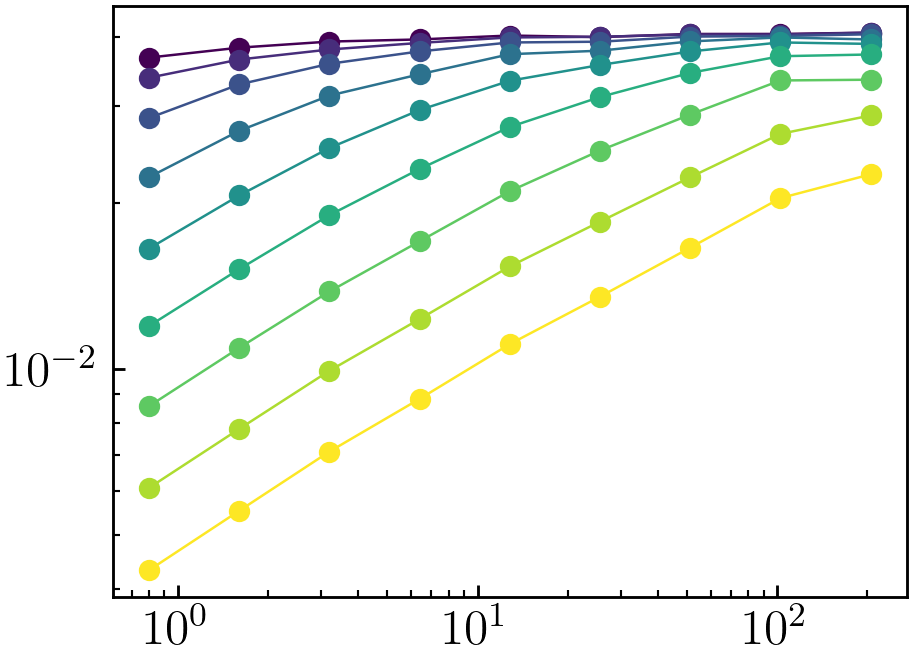

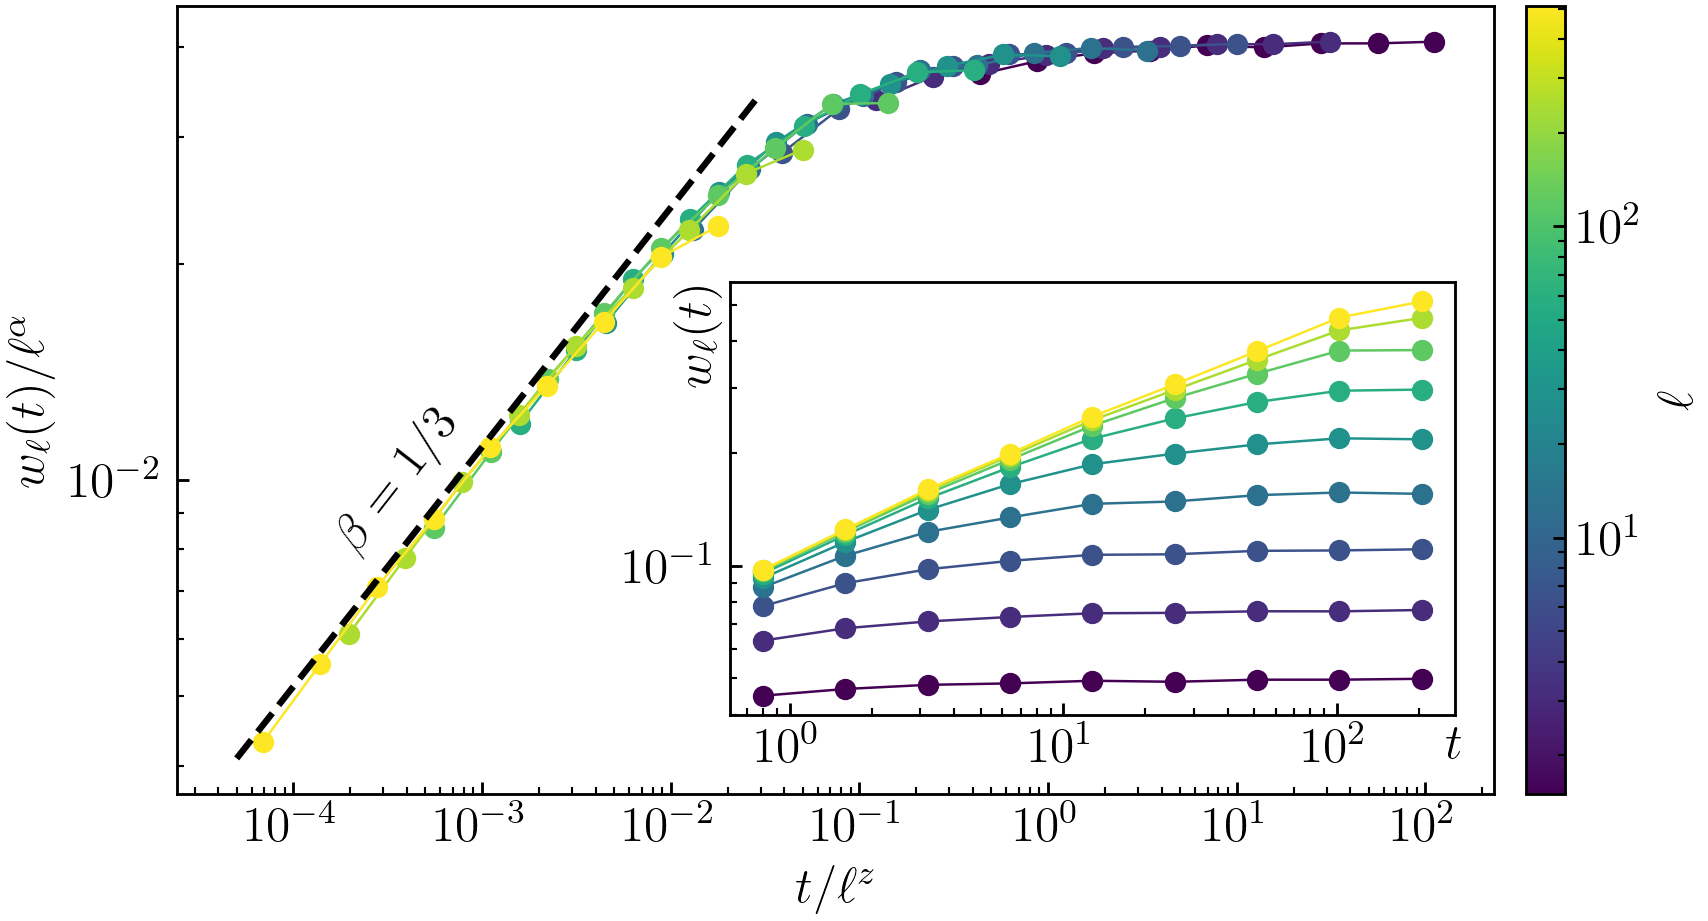

In [14]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(4, 3))
fig2, ax2 = plt.subplots(figsize=(4, 3))
fig3, ax3 = plt.subplots(figsize=(8, 4))

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

inset_ax = ax3.inset_axes([0.42,0.1,0.55,0.55])
inset_ax.set_xlabel("$t$")
inset_ax.set_ylabel("$w_\\ell(t)$")
inset_ax.yaxis.set_label_coords(-0.01, .88)
inset_ax.xaxis.set_label_coords(1., -0.02)

ax3.set_xlabel("$ t/\\ell^z$")
ax3.set_ylabel("$ w_\\ell(t)/\\ell^\\alpha$")


for i in range(nx):
    L = xx[i]
    ax.loglog(tt, w[:,i], '.-', lw=.7, ms=10,color=cm.viridis(i/(nx-1)))
    ax2.loglog(tt, w[:,i]/L**a, '.-', lw=.7, ms=10,color=cm.viridis(i/(nx-1)))
    ax3.loglog(tt/L**z, w[:,i]/L**a, '.-', lw=.7, ms=10,color=cm.viridis(i/(nx-1)))
    inset_ax.loglog(tt, w[:,i], '.-', lw=.7, ms=10,color=cm.viridis(i/(nx-1)))

norm = mpl.colors.LogNorm(vmin=xx[0], vmax=xx[-1])
sm = mpl.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
cbar = fig3.colorbar(sm, ax=ax3, pad=0.02)
cbar.set_label("$\\ell$")

TT = np.array([5e-5, 3e-2])
ax3.plot(TT, TT**b/9e0, 'k--', lw=1.8)
ax3.text(1.5e-4, 8.e-3, "$\\beta = 1/3$", rotation=52)

ax.tick_params(direction='in')
ax.tick_params(direction='in', which="minor")

ax3.tick_params(direction='in')
ax3.tick_params(direction='in', which="minor")

plt.show()
fig3.savefig("fig/figkpz.pdf")

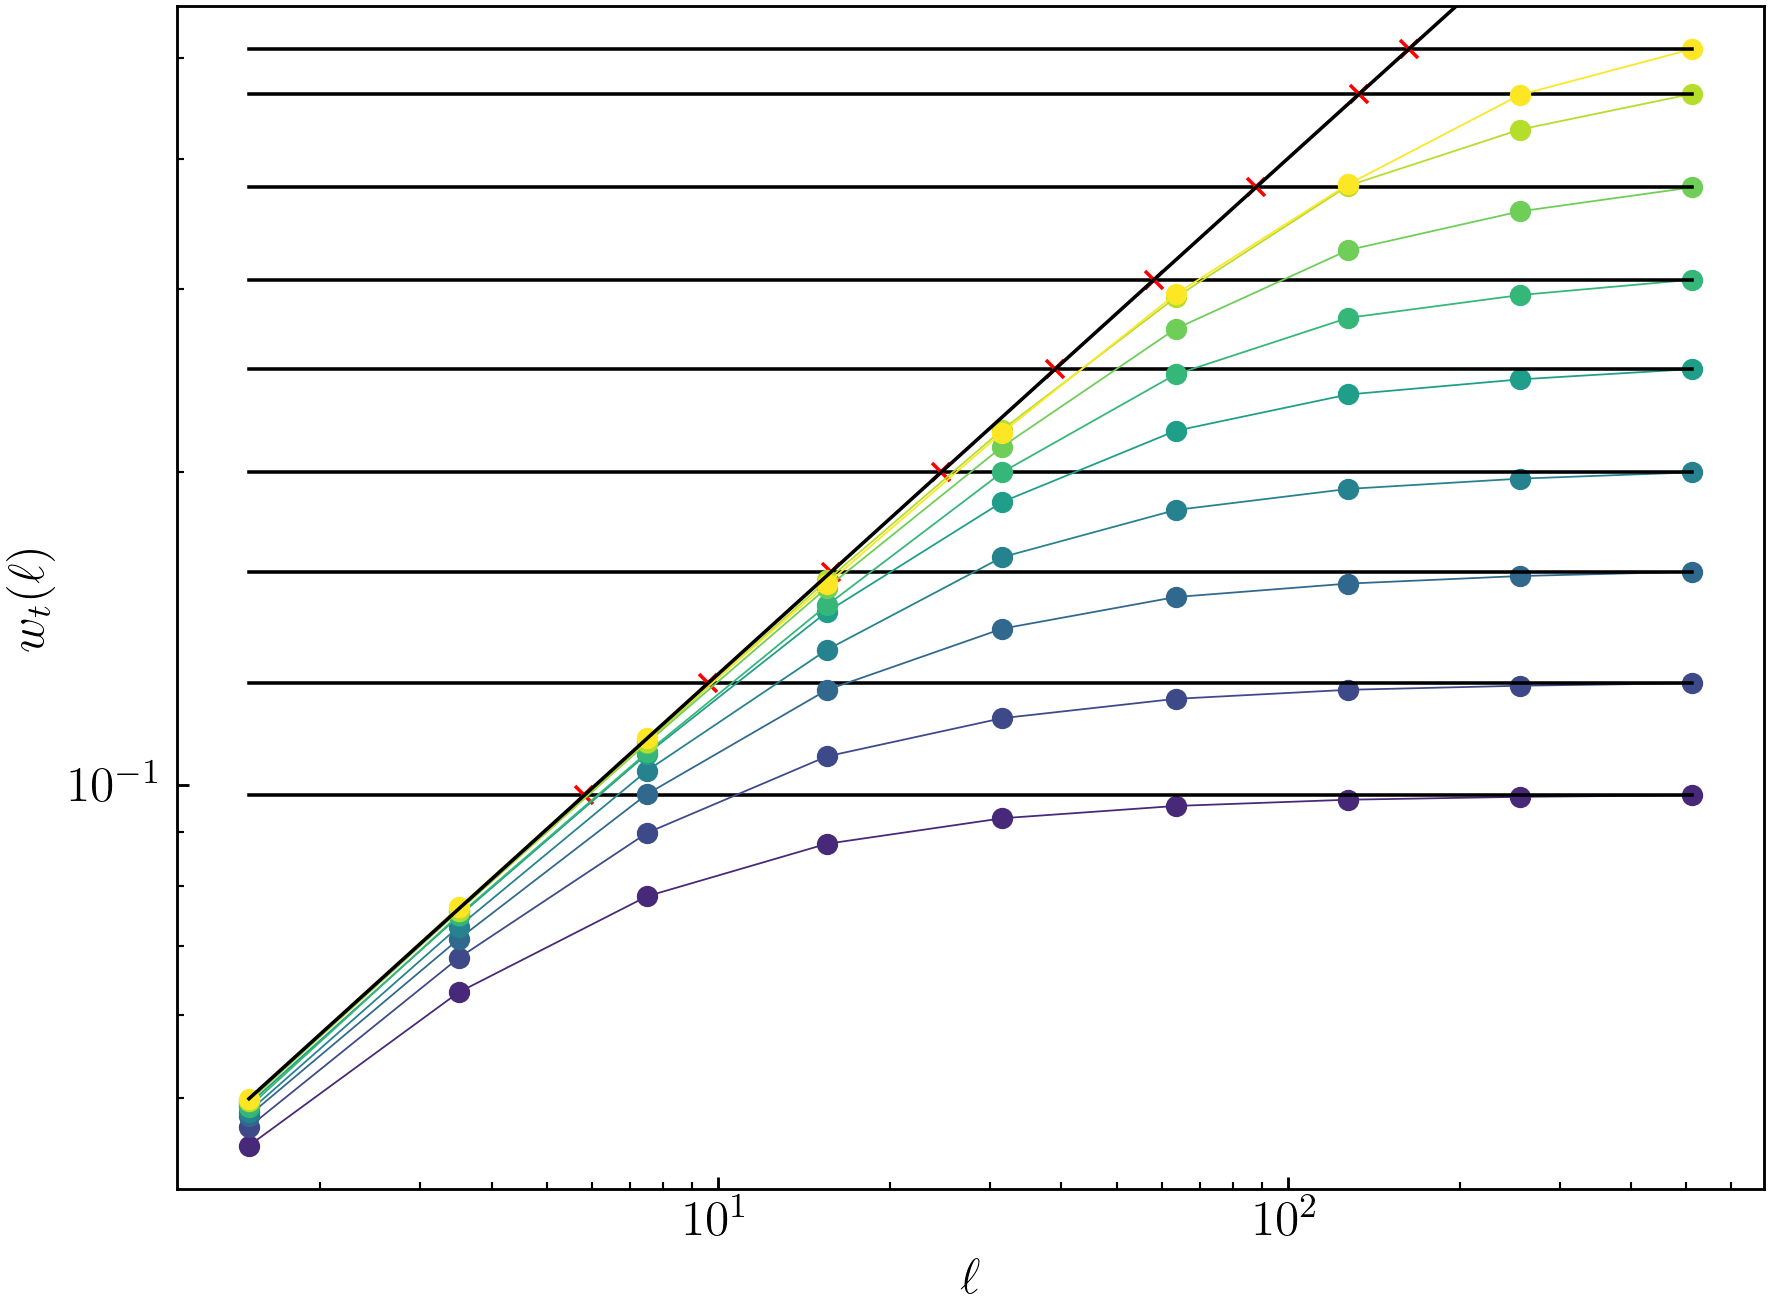

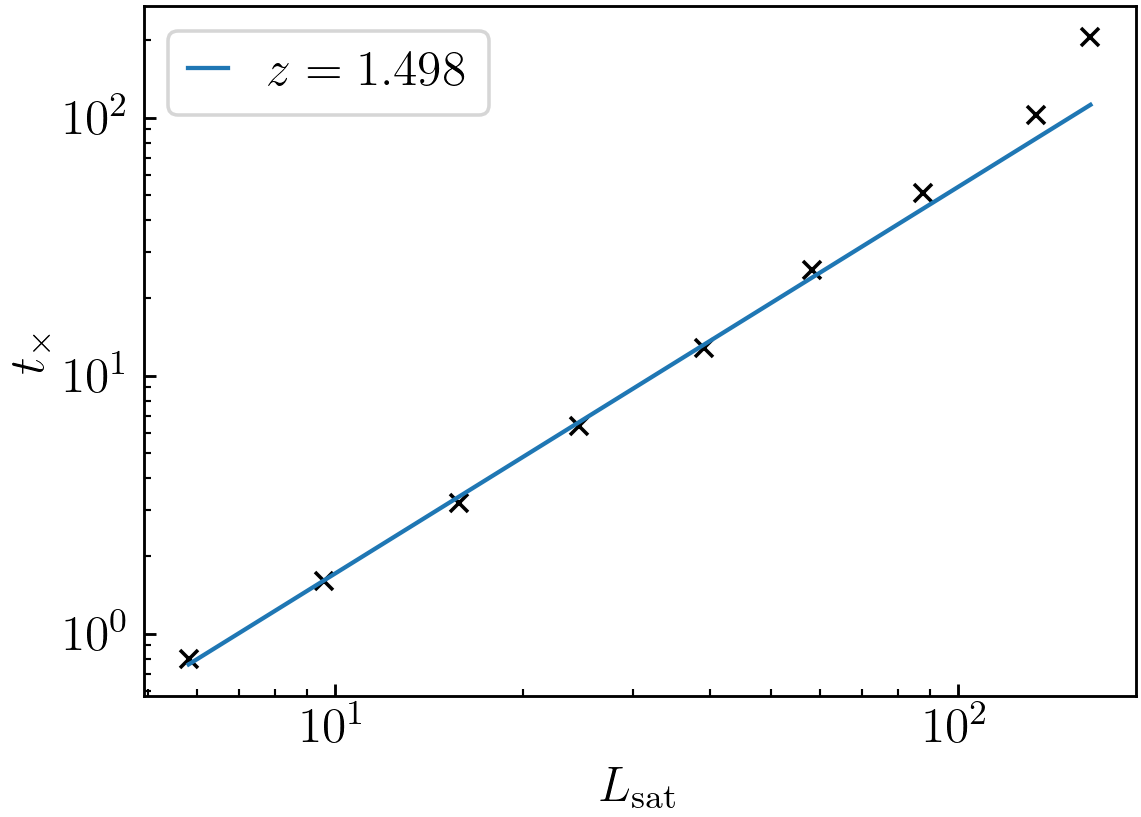

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel("$\\ell$")
ax.set_ylabel("$w_t(\\ell)$")

ws = []
ls = []

i = -1

dy = np.log(w[i,2]) - np.log(w[i,0])
dx = np.log(xx[2]) -  np.log(xx[0])
A = dy/dx
X = np.log(xx[[0,-1]])
B = np.log(w[i,0]) - A * np.log(xx[0])
Y = A * np.log(xx[[0,-1]]) + B
ax.plot(np.exp(X), np.exp(Y), 'k', lw=1, zorder=10)

for i in range(nt):
    T = tt[i]
    ax.loglog(xx, w[i,:], '.-', lw=.5, ms=10,color=cm.viridis((i+1)/nt))
    
    wsat = w[i, -1]
    ws.append(wsat)
    ax.plot(xx[[0,-1]], [wsat,wsat], 'k', lw=1)
    lsat = np.exp((np.log(wsat) - B) / A)
    ls.append(lsat)
    plt.plot(lsat, wsat, 'rx')

ls, ws = np.array(ls), np.array(ws)
ax.set_ylim(np.min(w)/1.1, np.max(w)*1.1)
plt.show()

fig, ax = plt.subplots()
plt.loglog(ls, tt, 'xk')

NN, MM = -3, None
z, c = np.polyfit(np.log(ls[MM:NN]), np.log(tt[MM:NN]), 1)
ax.plot(ls, np.exp(c)*ls**z, label='$z = {z:.3f}$'.format(z=z))

ax.legend()
ax.set_xlabel("$L_\\mathrm{sat}$")
ax.set_ylabel("$t_\\times$")
ax.set_yticklabels([], minor=True)
ax.set_xticklabels([], minor=True)
plt.show()

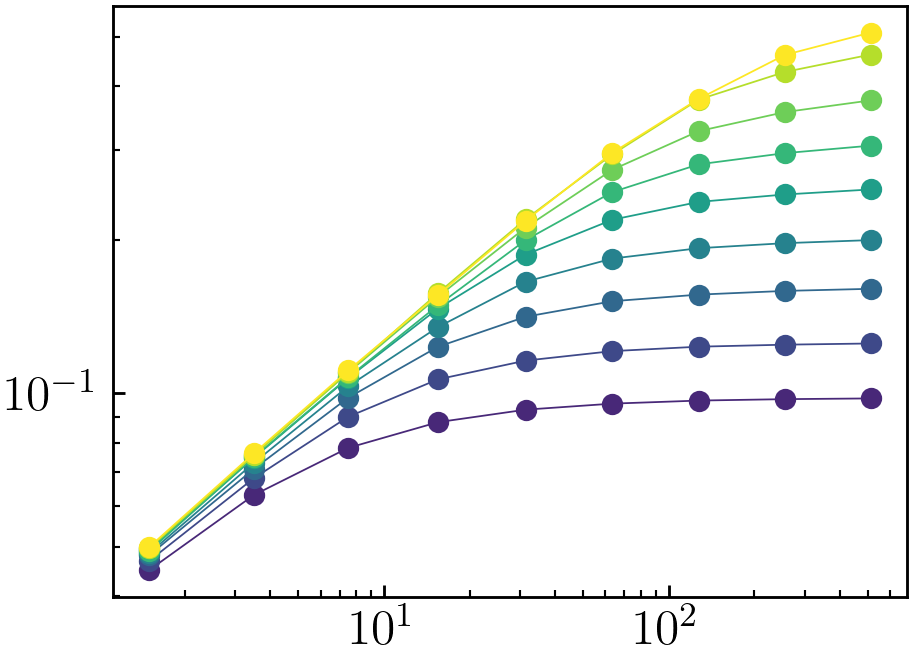

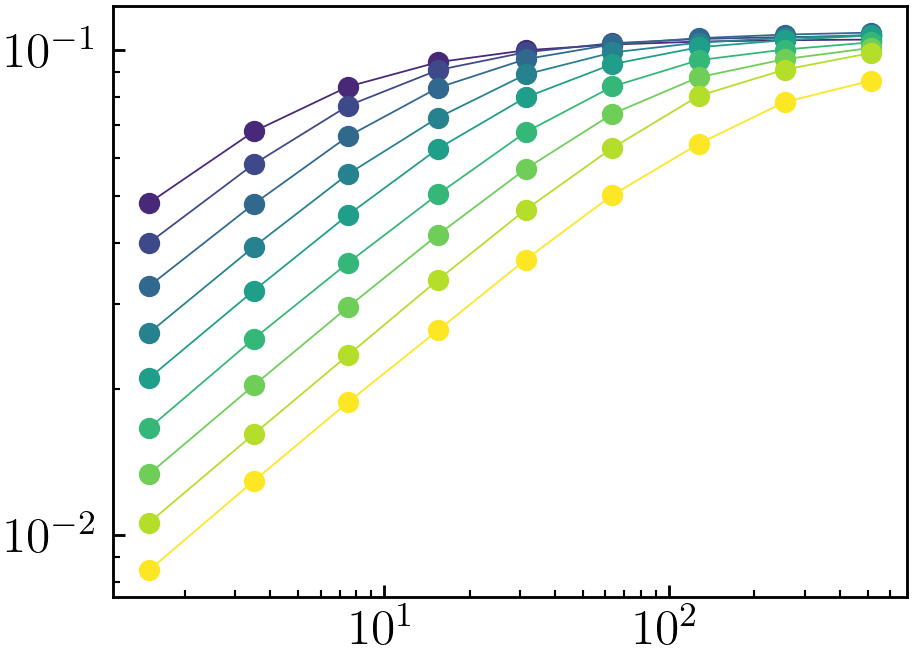

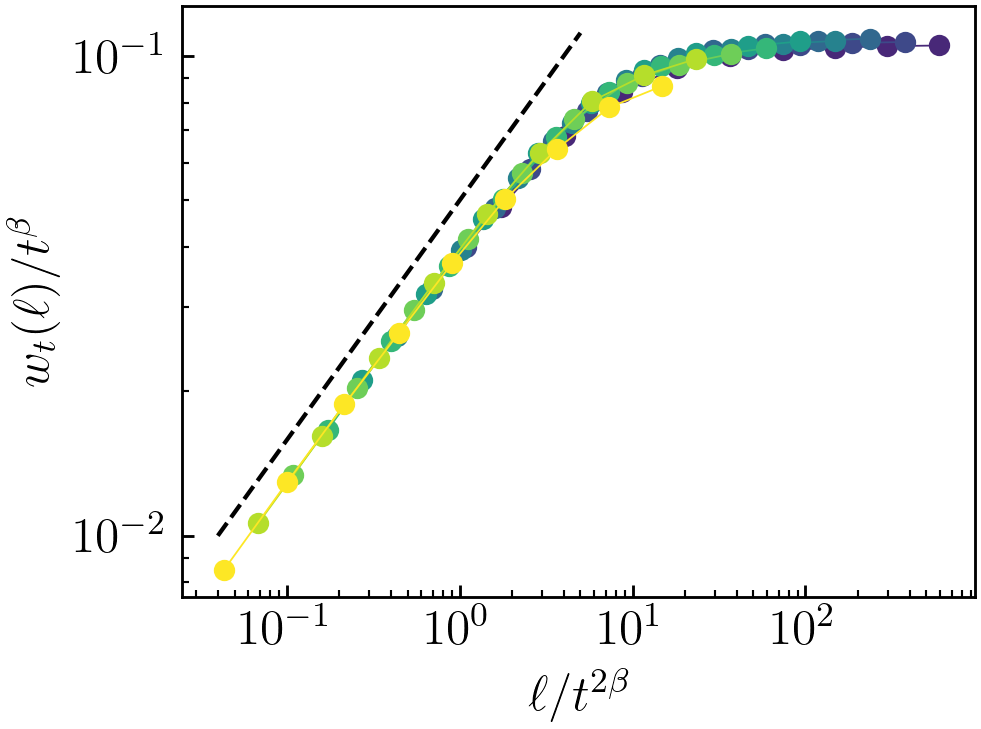

In [16]:
fig, ax     = plt.subplots(figsize=(4, 3)) 
fig2, ax2   = plt.subplots(figsize=(4, 3))
fig3, ax3   = plt.subplots(figsize=(4, 3))
ax3.set_xlabel("$\\ell/t^{2\\beta}$")
ax3.set_ylabel("$w _t(\\ell)/t^{\\beta}$")

for i in range(nt):
    T = tt[i]
    ax.loglog(xx, w[i,:], '.-', lw=.5, ms=10,color=cm.viridis((i+1)/nt))
    ax2.loglog(xx, w[i,:]/T**b, '.-', lw=.5, ms=10,color=cm.viridis((i+1)/nt))
    ax3.loglog(xx/T**(2*b), w[i,:]/T**b, '.-', lw=.5, ms=10,color=cm.viridis((i+1)/nt))

TT = np.array([4e-2, 5e0])
ax3.plot(TT, TT**a/2e1, 'k--')
ax.set_yticklabels([], minor=True)
ax.tick_params(direction='in')
ax.tick_params(direction='in', which="minor")
